# **Experiment Notebook - XGBoostRegressor**



## The Brief: 
This is work commissioned by an American retailer that has 10 stores across 3 different states: California (CA), Texas (TX) and Wisconsin (WI).

The task is building 1 forecasting model and 1 predictive model, and both will be deployed into production as API:

- The predictive model  accurately predict the sales revenue for a given item in a specific store at a given date.
- The forecasting model conducts a time-series analysis algorithm forecasts the total sales revenue across all stores and items for one week given a date.

The metric used to assess model performance is RMSE (Root Mean Squared Error).

This experiment notebook is aimed in developing the predictive model, and uses the XGBoostRegressor algorithm.

### 1. Load the dataset

In [1]:
# load modules
%load_ext autoreload
%autoreload 2

In [101]:
# pip install krml package
! pip install -i https://test.pypi.org/simple/ my_krml_24618288==2024.0.3.7

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: my_krml_24618288
    Found existing installation: my_krml_24618288 2024.0.3.6
    Uninstalling my_krml_24618288-2024.0.3.6:
      Successfully uninstalled my_krml_24618288-2024.0.3.6


In [3]:
# data libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_data = pd.read_csv("../../data/processed/df_train_nonull.csv", index_col=0)
df_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales_qty,date,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,8.288651
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,3.970000
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,2.970000
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,4.496375
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,2.959356


### 2. Explore the datasets

#### 2.1 Exploration

In [7]:
print('Initial train shape: ', df_data.shape)

Initial train shape:  (46985090, 10)


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46985090 entries, 0 to 46985089
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   sales_qty   int64  
 7   date        object 
 8   wm_yr_wk    int64  
 9   sell_price  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 3.9+ GB


In [9]:
# check for duplicates
df_data[df_data.duplicated]

,id,item_id,dept_id,cat_id,store_id,state_id,sales_qty,date,wm_yr_wk,sell_price


In [10]:
df_data.isna().sum()

id            0
item_id       0
dept_id       0
cat_id        0
store_id      0
state_id      0
sales_qty     0
date          0
wm_yr_wk      0
sell_price    0
dtype: int64

#### 2.2 Preprocessing

In [11]:
# split the dataset for initial EDA
df_data['date'] = pd.to_datetime(df_data['date'])

date_filter = (df_data['date'] >= '2014-01-01') & (df_data['date'] <= '2015-12-31')
df_explore = df_data[date_filter]

del(df_data)

In [12]:
df_explore.describe()

,sales_qty,date,wm_yr_wk,sell_price
count,1.442177e+07,14421770,1.442177e+07,1.442177e+07
mean,1.179144e+00,2014-08-25 00:00:00.000001536,1.143469e+04,4.458231e+00
min,0.000000e+00,2014-01-01 00:00:00,1.134900e+04,1.000000e-02
25%,0.000000e+00,2014-04-29 00:00:00,1.141300e+04,2.180000e+00
50%,0.000000e+00,2014-08-25 00:00:00,1.143000e+04,3.480000e+00
75%,1.000000e+00,2014-12-21 00:00:00,1.144700e+04,5.840000e+00
max,6.060000e+02,2015-04-18 00:00:00,1.151200e+04,4.878000e+01
std,3.632711e+00,NaN,3.903018e+01,3.513634e+00


In [13]:
print('Random sample dataset: ', df_explore.shape)
df_explore.head()

Random sample dataset:  (14421770, 10)


,id,item_id,dept_id,cat_id,store_id,state_id,sales_qty,date,wm_yr_wk,sell_price
32563320,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,2014-01-01,11349,8.26
32563321,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2014-01-01,11349,3.97
32563322,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2014-01-01,11349,2.97
32563323,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,2,2014-01-01,11349,4.64
32563324,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,2014-01-01,11349,3.08


In [14]:
# assessment brief features: date, store_id, item_id

# categorical columns
cat_cols = ['item_id','store_id']

# unique columns
uniq_cols = ['id']

# cols to drop
drop_cols_targets = ['sales_qty', 'sell_price']

drop_cols = ['dept_id', 'cat_id', 'state_id']

# dropped features from feature impact analysis
# drop_feats = ['porpag', 'drtg', 'twoP_per', 'dbpm', 'obpm', 'bpm', 'FTM', 'type', 'TPM']
                  

### 3. Explore Target variable

In [15]:
target = 'sales_rev'

In [16]:
df_explore[target] = df_explore['sales_qty'] * df_explore['sell_price']

In [17]:
df_explore.drop(uniq_cols + drop_cols + drop_cols_targets, axis=1, inplace=True)

In [18]:
df_explore[target].describe()

count    1.442177e+07
mean     3.463408e+00
std      9.604365e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.880000e+00
max      1.618380e+03
Name: sales_rev, dtype: float64

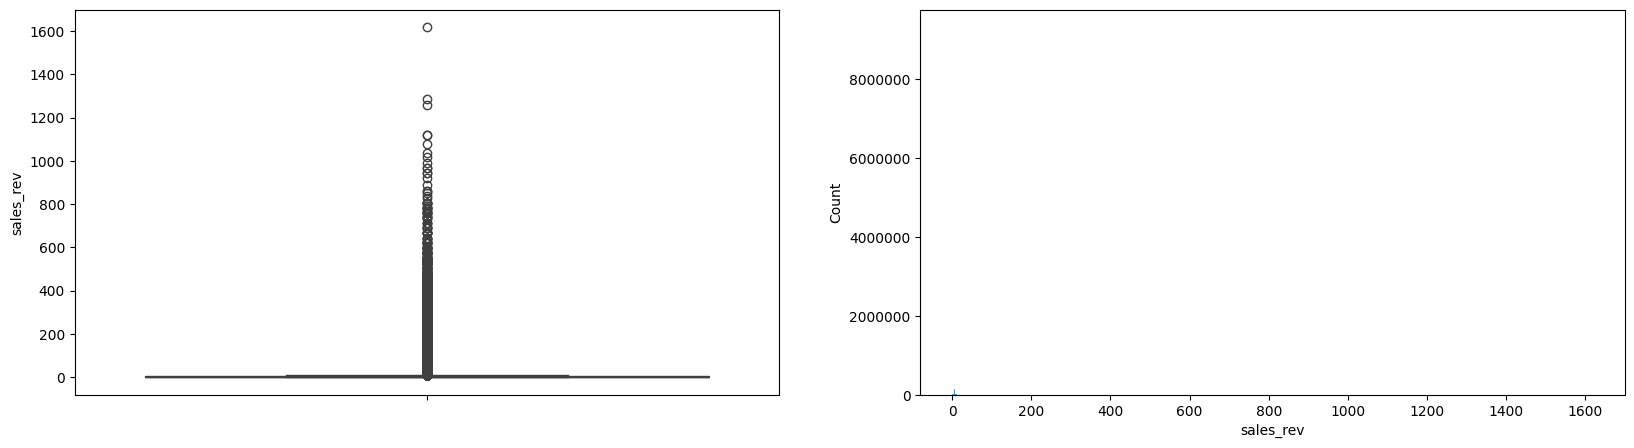

In [19]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax = ax.flatten()

sns.boxplot(df_explore[target], ax=ax[0])
sns.histplot(df_explore[target], ax=ax[1])

plt.ticklabel_format(style='plain')
plt.show()

The revenue distribution is heavily skewed towards 0. This is expected as the dataset includes daily sales for all items across the whole company.

### 4. Explore Features

In [20]:
df_explore.head()

,item_id,store_id,date,wm_yr_wk,sales_rev
32563320,HOBBIES_1_001,CA_1,2014-01-01,11349,8.26
32563321,HOBBIES_1_002,CA_1,2014-01-01,11349,0.00
32563322,HOBBIES_1_003,CA_1,2014-01-01,11349,0.00
32563323,HOBBIES_1_004,CA_1,2014-01-01,11349,9.28
32563324,HOBBIES_1_005,CA_1,2014-01-01,11349,3.08


#### Week Month Year Week

<Axes: xlabel='wm_yr_wk', ylabel='sales_rev'>

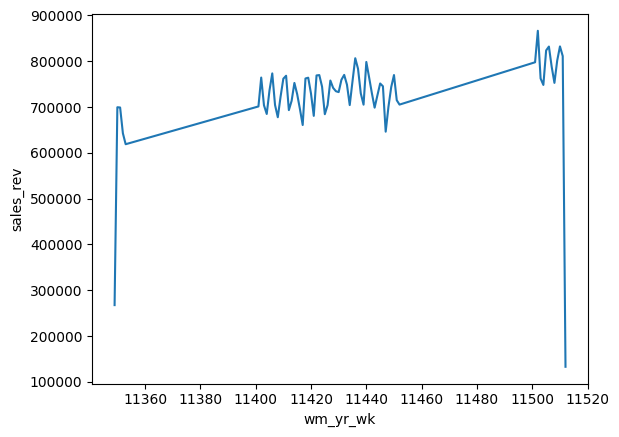

In [21]:
sns.lineplot(df_explore.groupby('wm_yr_wk')[target].sum().sort_index())

There indeed is some weekly pattern present in the data. However, how the week ID was generated is not clearly defined. Will need to create a function to recreate this for unseen dates in the API. 

Dropoffs are expected of sampling where the data was not cut perfectly into the week.

In [22]:
df_explore[df_explore['wm_yr_wk'] == 11350][['wm_yr_wk', 'date']].drop_duplicates()

,wm_yr_wk,date
32654790,11350,2014-01-04
32685280,11350,2014-01-05
32715770,11350,2014-01-06
32746260,11350,2014-01-07
32776750,11350,2014-01-08
32807240,11350,2014-01-09
32837730,11350,2014-01-10


In [23]:
df_explore[df_explore['wm_yr_wk'] == 11351][['wm_yr_wk', 'date']].drop_duplicates()

,wm_yr_wk,date
32868220,11351,2014-01-11
32898710,11351,2014-01-12
32929200,11351,2014-01-13
32959690,11351,2014-01-14
32990180,11351,2014-01-15
33020670,11351,2014-01-16
33051160,11351,2014-01-17


In [24]:
import datetime
import math

def wk_id_generator(date: str):
    benchmark_date = datetime.datetime.strptime('2014-01-04', '%Y-%m-%d')
    benchmark_wk = 11350
    
    days_diff = (datetime.datetime.strptime(date, '%Y-%m-%d') - benchmark_date).days
    week_diff = math.floor(days_diff/7)
    wk_id = benchmark_wk + week_diff

    return wk_id
    

In [25]:
wk_id_generator('2014-01-01')

11349

#### Categorical Features v Target

In [66]:
# from my_krml_24618288.features.cat_eda_display import plot_categ_feats

#### Day of Week

In [26]:
df_explore['day_of_week'] = df_explore['date'].dt.dayofweek

<Axes: xlabel='day_of_week'>

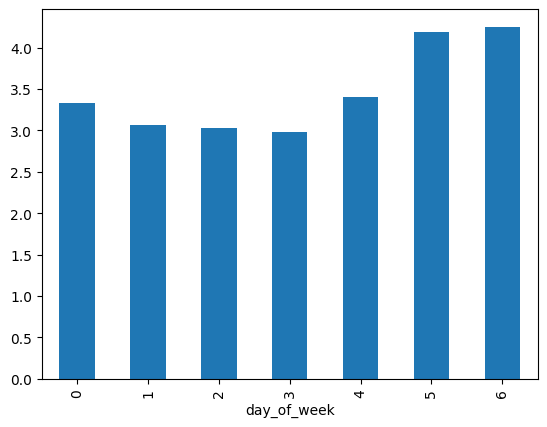

In [27]:
df_explore.groupby(['day_of_week'])[target].mean().plot(kind='bar')

Some variation in day of week. Generally lowest from Monday to Wed, picks up Thursday, higher sales on Friday and Sat, then drops down by Sunday

#### Is Holiday

In [28]:
df_calendar_events = pd.read_csv('../../data/raw/calendar_events.csv')
df_calendar_events.head()

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


In [29]:
df_calendar_events.duplicated().sum()

np.int64(0)

In [30]:
# dates with more than one events
df_calendar_events.date.duplicated().sum()

np.int64(5)

In [31]:
df_calendar_events['date'] = pd.to_datetime(df_calendar_events['date'])

In [32]:
df_calendar_events['event_type'].nunique()

4

In [33]:
df_events = df_calendar_events.pivot_table(index=['date'], columns=['event_type'], aggfunc=[len], fill_value=0).droplevel(level=[0,1], axis=1)
df_events.head()

event_type,Cultural,National,Religious,Sporting
date,,,,
2011-02-06,0,0,0,1
2011-02-14,1,0,0,0
2011-02-21,0,1,0,0
2011-03-09,0,0,1,0
2011-03-16,0,0,1,0


In [34]:
df_explore = pd.merge(df_explore, df_events, left_on='date', right_on='date', how='left')
print('Checking shape: ', df_explore.shape)
df_explore.head()

Checking shape:  (14421770, 10)


,item_id,store_id,date,wm_yr_wk,sales_rev,day_of_week,Cultural,National,Religious,Sporting
0,HOBBIES_1_001,CA_1,2014-01-01,11349,8.26,2,0.0,1.0,0.0,0.0
1,HOBBIES_1_002,CA_1,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0
2,HOBBIES_1_003,CA_1,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0
3,HOBBIES_1_004,CA_1,2014-01-01,11349,9.28,2,0.0,1.0,0.0,0.0
4,HOBBIES_1_005,CA_1,2014-01-01,11349,3.08,2,0.0,1.0,0.0,0.0


In [35]:
df_events.to_csv('../../data/processed/df_events.csv')

#### Item ID

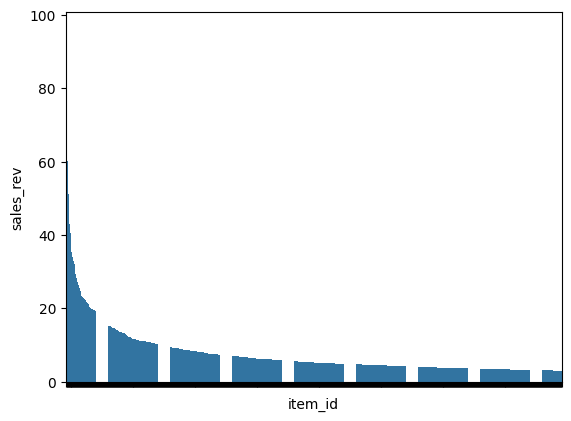

In [36]:
fig, ax = plt.subplots()

sns.barplot(df_explore.groupby(['item_id'])[target].mean().sort_values(ascending=False)[0:1000], ax=ax)

plt.gca().set_xticklabels([])
plt.show()

Some item ids having higher average sales revenue than others

In [37]:
df_explore['item_id'].nunique()

3049

In [38]:
# checking item IDs with 0 average rev
len(df_explore.groupby(['item_id'])[target].sum()[df_explore.groupby('item_id')[target].sum() == 0])

3

In [44]:
# using target encoder to process Item ID
from sklearn.preprocessing import TargetEncoder

train_mask = (df_explore['date'] >= '2014-01-01') & (df_explore['date'] <= '2014-12-31')

encoder = TargetEncoder(smooth="auto", random_state=10)
encoder.fit(df_explore[train_mask]['item_id'].values.reshape(-1, 1), df_explore[train_mask][target].values)
X_transformed = encoder.transform(df_explore['item_id'].values.reshape(-1, 1))

X_transformed[0:5]

array([[ 2.90691688],
       [ 1.03904097],
       [ 0.28801903],
       [11.08345351],
       [ 1.80575845]])

In [45]:
df_explore['item_id_encoded'] = X_transformed

In [46]:
df_explore.head()

,item_id,store_id,date,wm_yr_wk,sales_rev,day_of_week,Cultural,National,Religious,Sporting,item_id_encoded
0,HOBBIES_1_001,CA_1,2014-01-01,11349,8.26,2,0.0,1.0,0.0,0.0,2.906917
1,HOBBIES_1_002,CA_1,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0,1.039041
2,HOBBIES_1_003,CA_1,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0,0.288019
3,HOBBIES_1_004,CA_1,2014-01-01,11349,9.28,2,0.0,1.0,0.0,0.0,11.083454
4,HOBBIES_1_005,CA_1,2014-01-01,11349,3.08,2,0.0,1.0,0.0,0.0,1.805758


In [47]:
# drop item id inplace of item id encoded
df_explore.drop('item_id', axis=1, inplace=True)

In [48]:
import joblib

In [49]:
# saving target encoder
joblib.dump(encoder, '../../models/target_encoder.joblib')

['../../models/target_encoder.joblib']

#### Store ID

<Axes: xlabel='store_id'>

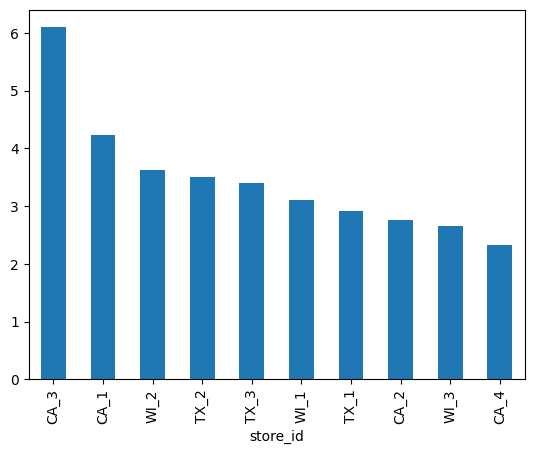

In [50]:
df_explore.groupby(['store_id'])[target].mean().sort_values(ascending=False).plot(kind='bar')

Some variation with store ID

### 5. Data Preparation

In [51]:
# create dummy variables and concat for categorical variable store_id
# do not drop first to account for new stores

df = pd.concat([df_explore, pd.get_dummies(df_explore['store_id'], drop_first=False, prefix='store_id', dtype=float)], axis=1)
df.drop('store_id', axis=1, inplace=True)

In [52]:
df.head()

,date,wm_yr_wk,sales_rev,day_of_week,Cultural,National,Religious,Sporting,item_id_encoded,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3
0,2014-01-01,11349,8.26,2,0.0,1.0,0.0,0.0,2.906917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0,1.039041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01,11349,0.00,2,0.0,1.0,0.0,0.0,0.288019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01,11349,9.28,2,0.0,1.0,0.0,0.0,11.083454,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01,11349,3.08,2,0.0,1.0,0.0,0.0,1.805758,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14421770 entries, 0 to 14421769
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   wm_yr_wk         int64         
 2   sales_rev        float64       
 3   day_of_week      int32         
 4   Cultural         float64       
 5   National         float64       
 6   Religious        float64       
 7   Sporting         float64       
 8   item_id_encoded  float64       
 9   store_id_CA_1    float64       
 10  store_id_CA_2    float64       
 11  store_id_CA_3    float64       
 12  store_id_CA_4    float64       
 13  store_id_TX_1    float64       
 14  store_id_TX_2    float64       
 15  store_id_TX_3    float64       
 16  store_id_WI_1    float64       
 17  store_id_WI_2    float64       
 18  store_id_WI_3    float64       
dtypes: datetime64[ns](1), float64(16), int32(1), int64(1)
memory usage: 2.0 GB


In [54]:
# creating checkpoint for data processing
df.to_csv('../../data/processed/df_train_processed.csv')

In [55]:
# deleting variable to save memory
del(df_explore)

### 6. Splitting Dataset

In [4]:
df = pd.read_csv('../../data/processed/df_train_processed.csv')
print(df.shape)

(11128850, 15)


In [56]:
# creating filters for train and test sets
train_mask = (df['date'] >= '2014-01-01') & (df['date'] <= '2014-12-31')
test_mask = (df['date'] >= '2015-01-01') & (df['date'] <= '2015-12-31')

df_train = df[train_mask].drop('date', axis=1)
df_test = df[test_mask].drop('date', axis=1)

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (11128850, 18)
Test shape:  (3292920, 18)


In [57]:
del(df)

In [61]:
from my_krml_24618288.data.sets import pop_target

X_train, y_train = pop_target(df_train, target)
X_test, y_test = pop_target(df_test, target)

In [59]:
# save sets into the data/processed folder
from grp_krml_group3.data.sets import save_sets

In [63]:
save_sets(X_train, y_train, None, None, X_test, y_test, path='../../data/processed/save_sets')

### 7. Baseline Model

In [64]:
from grp_krml_group3.models.null import NullRegressor

In [65]:
base_model = NullRegressor()

In [66]:
# creating baseline predictions with the same shape as the train, and test sets
train_baseline_preds = base_model.fit_predict(y_train)
test_baseline_preds = base_model.fit_predict(y_test)

In [67]:
from grp_krml_group3.models.performance import print_regressor_scores

In [68]:
print_regressor_scores(y_actuals=y_train, y_preds=train_baseline_preds)

RMSE None: 9.260573745526159
MAE None: 4.641348632065445


In [69]:
print_regressor_scores(y_actuals=y_test, y_preds=test_baseline_preds)

RMSE None: 10.682095582363939
MAE None: 4.879632032335002


Generally high RMSE and MAE when accounting for the distribution of the data

### 8. Train Machine Learning Model

In [71]:
import xgboost as xgb

In [73]:
# initialize model
model = xgb.XGBRegressor(eval_metric='rmse', booster='gbtree', random_state=10)

### 9. Assess Model Performance

In [97]:
# KFold cross validation
from sklearn.metrics import root_mean_squared_error as rmse, mean_absolute_error as mae
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from my_krml_24618288.models.performance import evaluate_cv_predictions_reg

# Doing 3 splits
cv = KFold(n_splits=3, shuffle=True, random_state=10)

,Mean,STD,Median
neg_root_mean_squared_error,7.270349,0.008993,7.270183
neg_mean_absolute_error,3.445925,0.001635,3.445407


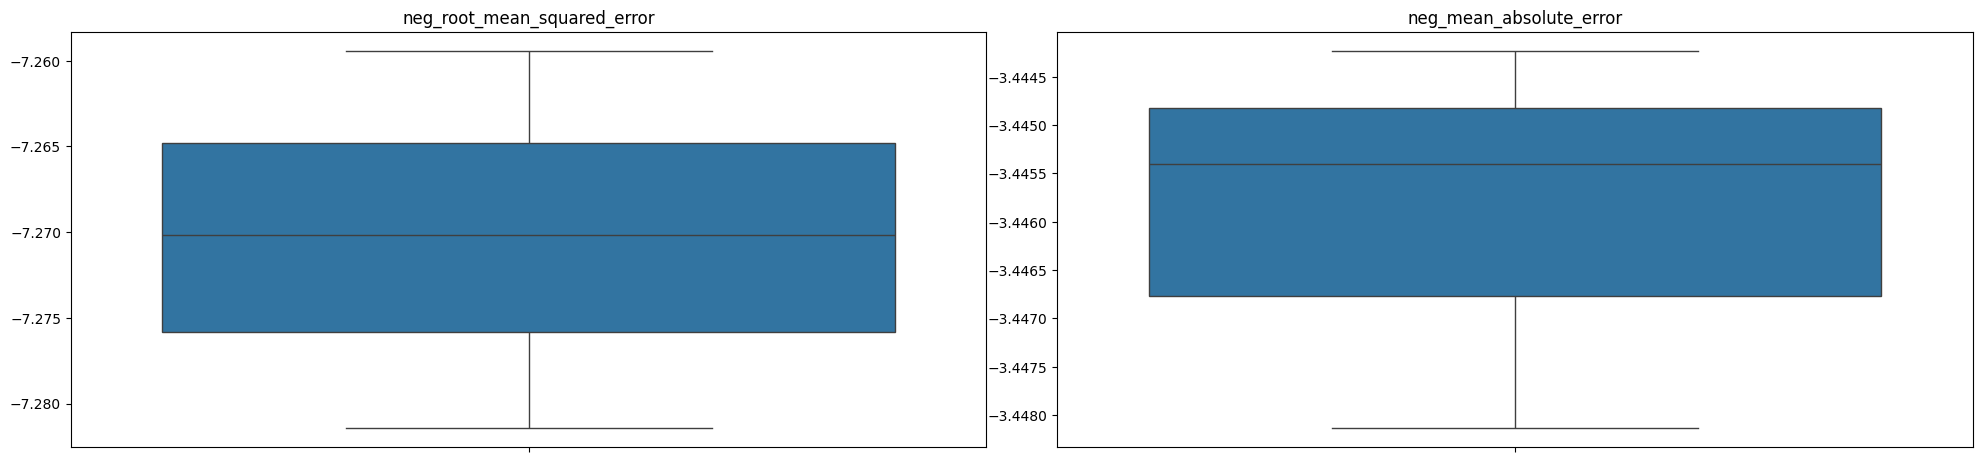

In [85]:
# scores for undersampling training
evaluate_cv_predictions_reg(X_train, y_train, model)

In [89]:
X_train_samp, y_train_samp = pop_target(df_train.sample(frac=0.5), target)

,Mean,STD,Median
neg_root_mean_squared_error,7.254957,0.025535,7.265955
neg_mean_absolute_error,3.448236,0.003649,3.446406


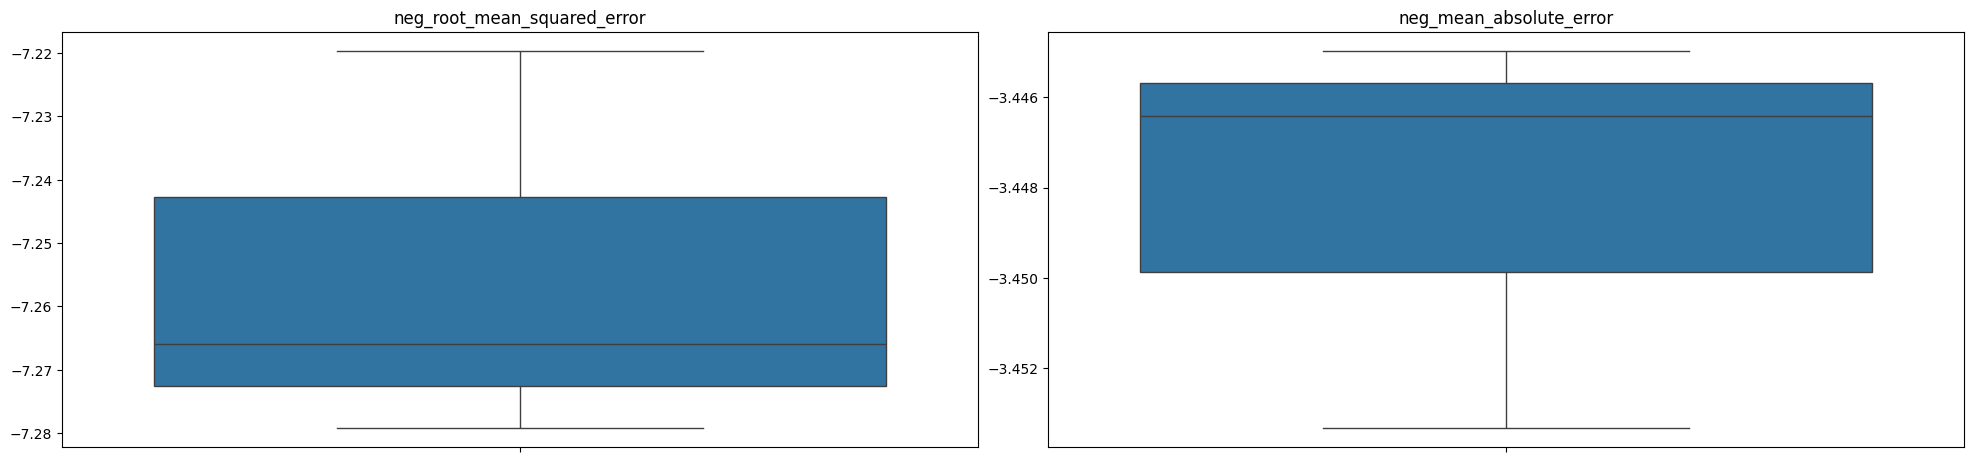

In [102]:
evaluate_cv_predictions_reg(X_train_samp, y_train_samp, model, cv)

The initial xgboostregressor model performs better than the basemodel. Furthermore, based on sampling 50% the train set, it returns similar scores. Will train with 50% for initial testing

In [103]:
model.fit(X_train_samp, y_train_samp)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [105]:
# saving initial xgboost model
joblib.dump(model,  '../../models/xgbregressor_initial.joblib')

['../../models/xgbregressor_initial.joblib']

### 10. Hyperparameter Tuning

In [106]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [155]:
# defining optimisation function
def xgb_rmse_cv(params, random_state=10, cv=cv, X=X_train_samp, y=y_train_samp):
    params = {
              'max_depth': int(params['max_depth']), 
             'learning_rate': np.log(params['learning_rate']),
             'subsample': np.log(params['subsample']),
             'reg_lambda': np.log(params['reg_lambda']),
             'reg_alpha': np.log(params['reg_alpha']),
             'min_child_weight': int(params['min_child_weight'])}
    
    model = xgb.XGBRegressor(eval_metric='rmse', booster='gbtree', random_state=10, **params)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

    return score

In [156]:
%%time

n_iter=10 #limiting to ten iterations for resource purposes

# possible values of parameters
space = {
       'max_depth' : hp.quniform('max_depth', 5, 10, 1),
       'learning_rate': hp.loguniform('learning_rate', 1e-2, 0.2),
       'subsample': hp.loguniform('subsample', 0.7, 0.95),
       'reg_lambda': hp.loguniform('reg_lambda', 1e-2, 100),
       'reg_alpha': hp.loguniform('reg_alpha', 1e-2, 100),
       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=xgb_rmse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(10) # fixing random state for the reproducibility
         )

print("Best MSE {:.3f} params {}".format( xgb_rmse_cv(best), best))

100%|████████████████████████████████████████████████| 10/10 [19:23<00:00, 116.39s/trial, best loss: 7.248233425227871]
Best MSE 7.248 params {'learning_rate': np.float64(1.1776383371860142), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(5.0), 'reg_alpha': np.float64(2.0460755251135506e+37), 'reg_lambda': np.float64(1.9748841869537638e+43), 'subsample': np.float64(2.185830430287402)}
CPU times: total: 26.2 s
Wall time: 21min 4s


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

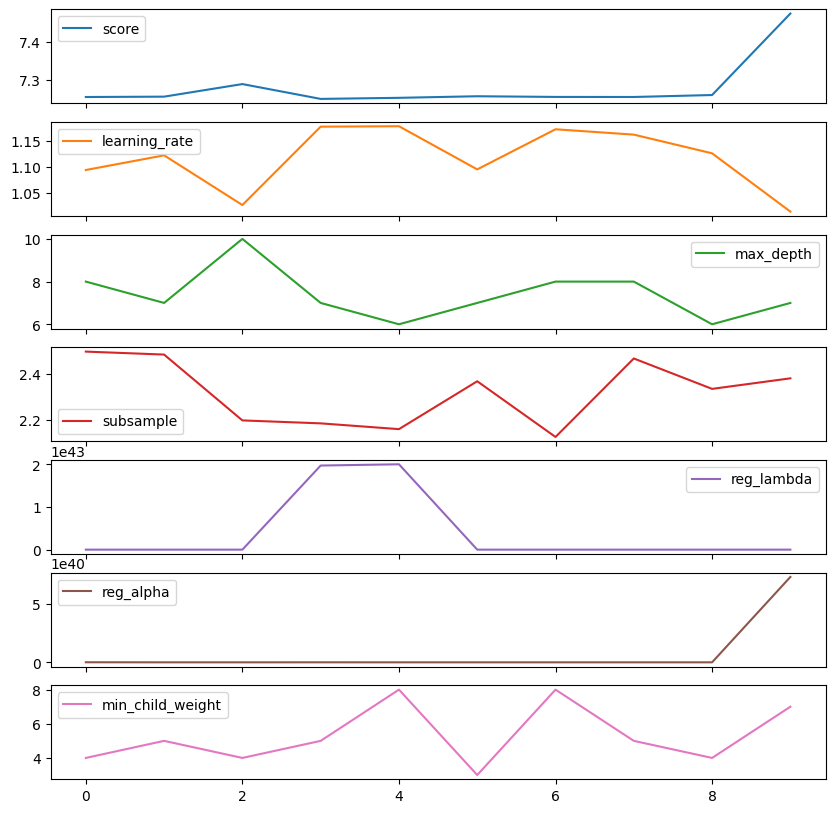

In [157]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['subsample'][0],
                       x['misc']['vals']['reg_lambda'][0],
                       x['misc']['vals']['reg_alpha'][0],
                       x['misc']['vals']['min_child_weight'][0]
                      ] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'subsample', 'reg_lambda', 'reg_alpha', 'min_child_weight'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

It's interesting that the model score stayed constant up until the last iteration. It would be interesting to see performance increasing iterations and including n_estimators as a hyperparameter.

In [158]:
best_t = best.copy()
best_t['max_depth'] = int(best['max_depth'])
# best_t['n_estimators'] = int(best['n_estimators'])
best_t['subsample'] = np.log(best['subsample'])
best_t['learning_rate'] = np.log(best['learning_rate'])
best_t['reg_lambda'] = np.log(best['reg_lambda'])
best_t['reg_alpha'] = np.log(best['reg_alpha'])
best_t['min_child_weight'] = int(best['min_child_weight'])
best_t

{'learning_rate': np.float64(0.16351102381753196),
 'max_depth': 7,
 'min_child_weight': 5,
 'reg_alpha': np.float64(85.91157202117307),
 'reg_lambda': np.float64(99.6916687558606),
 'subsample': np.float64(0.7819958159712886)}

[Optimised Train Results]


,Mean,STD,Median
neg_root_mean_squared_error,7.248233,0.023520,7.256149
neg_mean_absolute_error,3.450219,0.003191,3.448061


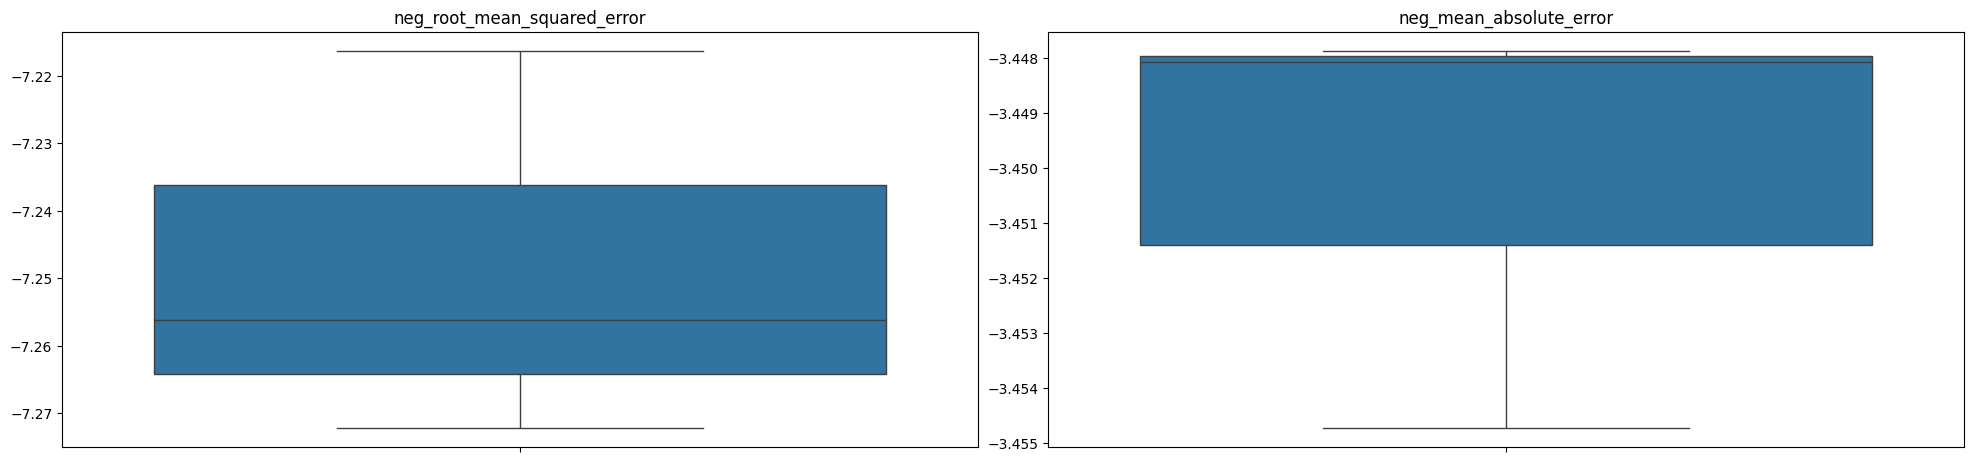

In [159]:
# generate cross validation predictions for undersampling training data
print('[Optimised Train Results]')

model_opt = xgb.XGBRegressor(eval_metric='rmse', booster='gbtree', random_state=10, **best_t)

evaluate_cv_predictions_reg(X_train_samp, y_train_samp, model_opt, cv)

The model had better scores after tuning. However, the model has not satisfied business requirements.

Next steps would be to increase hyperopt iterations, increase training size, and/or include n_estimators to the hyperparameter space.

In [160]:
model_opt.fit(X_train_samp, y_train_samp)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.16351102381753196), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [161]:
# saving optimised model
joblib.dump(model_opt,  '../../models/xgbregressor_hyperopt.joblib')

['../../models/xgbregressor_hyperopt.joblib']

### 11. Evaluate Test Data

,Mean,STD,Median
neg_root_mean_squared_error,9.024551,0.082139,9.040379
neg_mean_absolute_error,3.835742,0.004877,3.838012


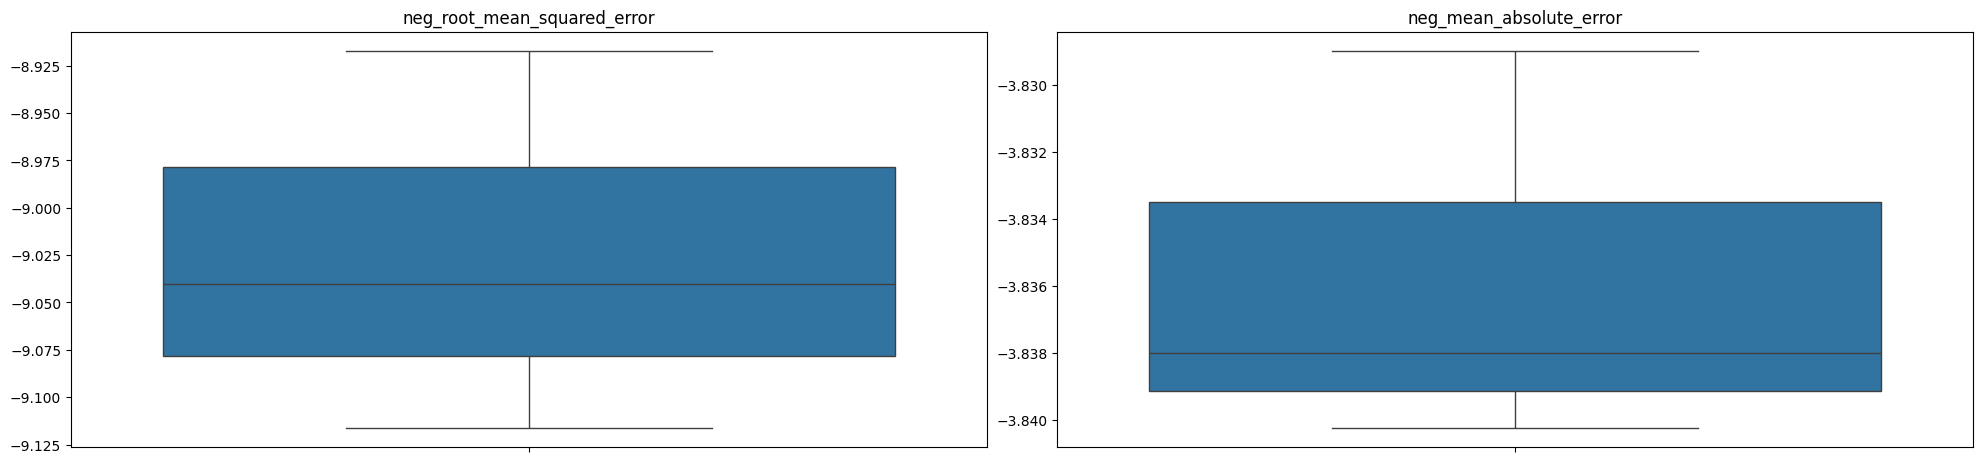

In [162]:
# computing the score on the test set
evaluate_cv_predictions_reg(X_test, y_test, model_opt, cv)

In conclusion, the test evaluations, after hyperparameter tuning as well as classification threshold tuning, show that the model is able to properly distinguish between the two classes, for unseen data. Given that it has satisfied the business requirements, strong considerations to deploy is recommended.

### 12. Feature Importance

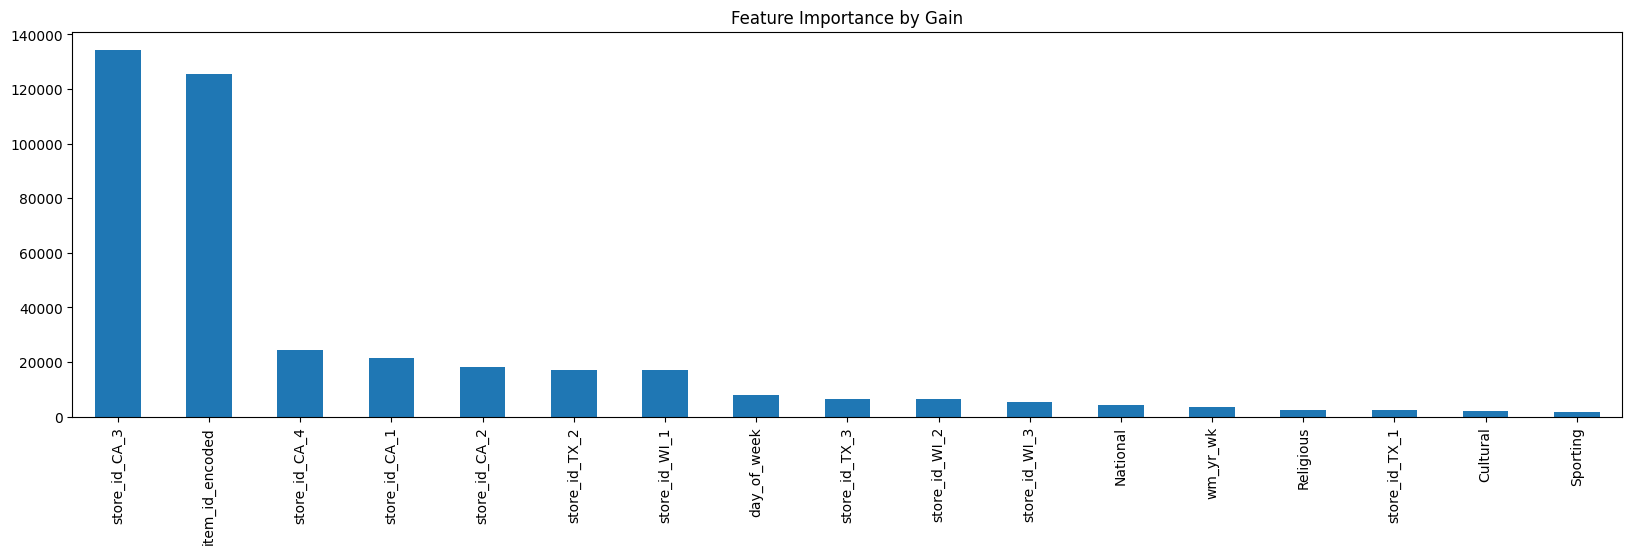

In [163]:
feature_important_gain = pd.Series(model_opt.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20,5))

ax = feature_important_gain.plot.bar()

ax.set_title('Feature Importance by Gain')

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

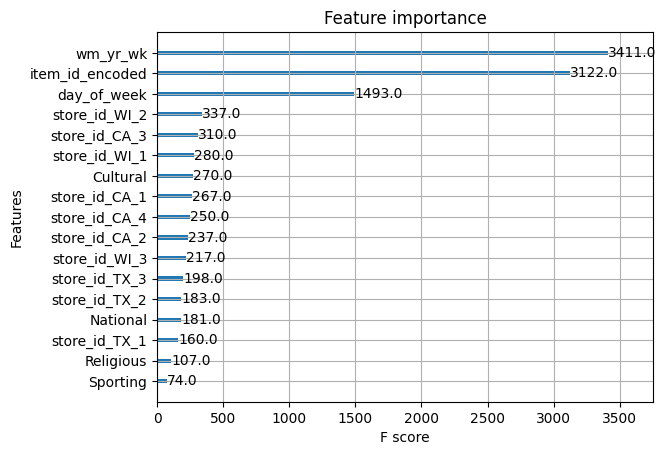

In [164]:
xgb.plot_importance(model_opt,max_num_features=None)

Some notes on feature importance:
- item_id_encoded has high importance scores
- as expected CA store 3 is a big player for the retailer
- both weight and gain, sporting scored at the bottom